<a href="https://colab.research.google.com/github/ebi19912/AI/blob/main/Copy_of_Lung_Cancer_ConvNeXtBase%2BVGG16_ChestClassification_wbce_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d khanfashee/nih-chest-x-ray-14-224x224-resized

!unzip nih-chest-x-ray-14-224x224-resized.zip

Streaming output truncated to the last 5000 lines.
  inflating: images-224/images-224/00028897_017.png  
  inflating: images-224/images-224/00028897_018.png  
  inflating: images-224/images-224/00028897_019.png  
  inflating: images-224/images-224/00028897_020.png  
  inflating: images-224/images-224/00028898_000.png  
  inflating: images-224/images-224/00028899_000.png  
  inflating: images-224/images-224/00028899_001.png  
  inflating: images-224/images-224/00028899_002.png  
  inflating: images-224/images-224/00028900_000.png  
  inflating: images-224/images-224/00028901_000.png  
  inflating: images-224/images-224/00028901_001.png  
  inflating: images-224/images-224/00028902_000.png  
  inflating: images-224/images-224/00028902_001.png  
  inflating: images-224/images-224/00028902_002.png  
  inflating: images-224/images-224/00028902_003.png  
  inflating: images-224/images-224/00028902_004.png  
  inflating: images-224/images-224/00028902_005.png  
  inflating: images-224/images-

In [ ]:

import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16 , ConvNeXtBase
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, BatchNormalization
from tensorflow.keras.layers import AvgPool2D, MaxPool2D, ReLU, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,
    matthews_corrcoef, average_precision_score, precision_recall_curve, roc_curve, roc_auc_score
)

from tensorflow.compat.v1.logging import INFO, set_verbosity
from tensorflow.python.framework.ops import disable_eager_execution
from matplotlib import rcParams
from keras.preprocessing import image





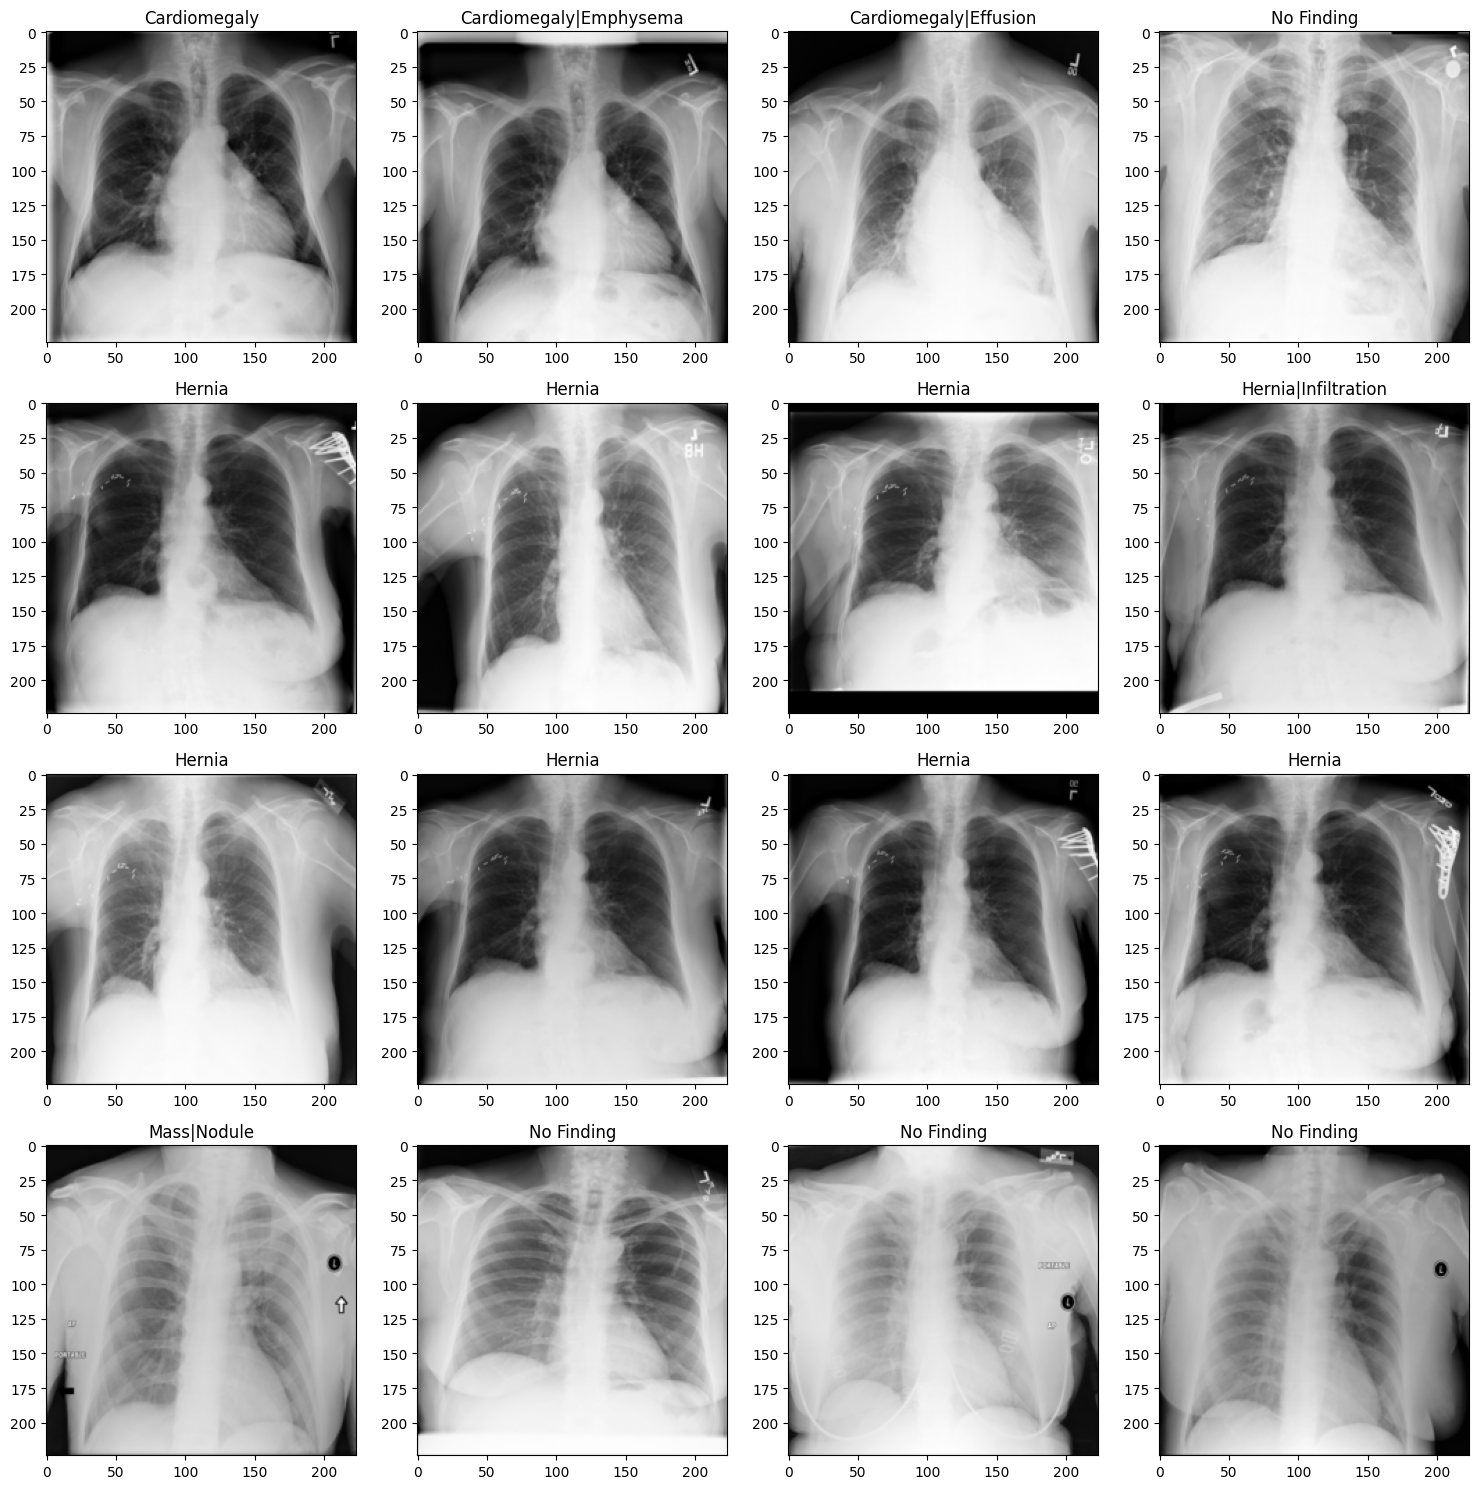

In [ ]:
dataframe = pd.read_csv("/content/Data_Entry_2017.csv")

#Enumerating all column names
columns = ["Image"]
for i in dataframe["Finding Labels"].values:
    for j in i.split("|"):
        if j not in columns:
            columns.append(j)
labels = columns.copy()
labels.remove("Image")

#Taking the first 77000 images from the master table as the train dataset
trainset = pd.DataFrame(columns = columns)
for i in range(77000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    trainset.loc[len(trainset)] = col

#Taking the next 16500 images from the master table as the validation dataset
valset = pd.DataFrame(columns = columns)
for i in range(77000, 93500):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    valset.loc[len(valset)] = col

#Taking the next 16500 images from the master table as the test dataset
testset = pd.DataFrame(columns = columns)
for i in range(93500, 110000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    testset.loc[len(testset)] = col

#Plotting first 16 images with their disease labels
img_dir = "/content/images-224/images-224"
plt.figure(figsize = (15,15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(img_dir, trainset["Image"][i])), cmap = "gray")
    plt.title(dataframe[dataframe["Image Index"] == trainset["Image"][i]].values[0][1])
plt.tight_layout()

In [ ]:
def isOverlap(s1, s2):
    total = set(s1).intersection(set(s2))
    return [len(total), total]

def overlapcheck(trainset, valset, testset):
    patid_train = []
    patid_val = []
    patid_test = []
    for name in trainset['Image'].values:
        patid_train.append(int(name.split("_")[0]))

    for name in valset['Image'].values:
        patid_val.append(int(name.split("_")[0]))

    for name in testset['Image'].values:
        patid_test.append(int(name.split("_")[0]))
    trte = isOverlap(patid_train, patid_test)
    teva = isOverlap(patid_test, patid_val)
    trva = isOverlap(patid_train, patid_val)
    print("Patient Overlap - Train and Test: ", trte[0])
    print("Patient Overlap - Test and Validation: ", teva[0])
    print("Patient Overlap - Train and Validation: ", trva[0])
    return trte, teva, trva

#Checking for overlaps between trainset, testset and validation set
trte, teva, trva = overlapcheck(trainset, valset, testset)

#Removing overlapping patients
for i in trva[1]:
    for name in trainset['Image'].values:
        if(int(name.split("_")[0]) == i):
            trainset.drop(trainset.loc[trainset['Image'] == name].index, inplace=True)

#Checking for overlaps after removing common patients
trte, teva, trva = overlapcheck(trainset, valset, testset)

Patient Overlap - Train and Test:  0
Patient Overlap - Test and Validation:  1
Patient Overlap - Train and Validation:  1
Patient Overlap - Train and Test:  0
Patient Overlap - Test and Validation:  1
Patient Overlap - Train and Validation:  0


In [ ]:
def label_counts(df):
    label_counts = df[labels].sum().sort_values(ascending=False)
    return label_counts

print("Training Data Label Counts:")
print(label_counts(trainset))
print("\nValidation Data Label Counts:")
print(label_counts(valset))
print("\nTest Data Label Counts:")
print(label_counts(testset))

Training Data Label Counts:
No Finding            42478
Infiltration          12360
Effusion               8826
Atelectasis            7854
Nodule                 4060
Mass                   3970
Consolidation          3327
Pneumothorax           3282
Pleural_Thickening     2190
Cardiomegaly           1983
Emphysema              1759
Edema                  1667
Fibrosis               1365
Pneumonia               957
Hernia                  162
dtype: int64

Validation Data Label Counts:
No Finding            7824
Infiltration          3926
Effusion              2232
Atelectasis           1929
Nodule                1269
Mass                   939
Pneumothorax           867
Pleural_Thickening     671
Consolidation          669
Cardiomegaly           400
Edema                  353
Emphysema              278
Pneumonia              214
Fibrosis               198
Hernia                  36
dtype: int64

Test Data Label Counts:
No Finding            8978
Infiltration          3188
Effusion   

In [ ]:

# Define the desired labels
desired_labels = ["No Finding", "Nodule", "Effusion", "Pneumothorax", "Mass", "Cardiomegaly"]

# Function to filter the DataFrame
def filter_dataframe(df, desired_labels):
    # Create a boolean mask for rows with any of the desired labels
    mask = df[desired_labels].any(axis=1)

    # Filter the DataFrame based on the mask
    filtered_df = df[mask]

    # Select only desired columns
    filtered_df = filtered_df[["Image"] + desired_labels]

    return filtered_df

# Apply the filter to each DataFrame
trainset_filtered = filter_dataframe(trainset, desired_labels)
valset_filtered = filter_dataframe(valset, desired_labels)
testset_filtered = filter_dataframe(testset, desired_labels)



In [ ]:

print("Training Set Filtered:")
print(trainset_filtered)
print("\nValidation Set Filtered:")
print(valset_filtered)
print("\nTest Set Filtered:")
testset_filtered


Training Set Filtered:
                  Image  No Finding  Nodule  Effusion  Pneumothorax  Mass  \
0      00000001_000.png           0       0         0             0     0   
1      00000001_001.png           0       0         0             0     0   
2      00000001_002.png           0       0         1             0     0   
3      00000002_000.png           1       0         0             0     0   
12     00000004_000.png           0       1         0             0     1   
...                 ...         ...     ...       ...           ...   ...   
76976  00018918_000.png           0       1         0             0     0   
76977  00018918_001.png           0       0         1             0     0   
76978  00018918_002.png           0       0         1             0     0   
76979  00018918_003.png           0       0         1             0     0   
76982  00018920_000.png           1       0         0             0     0   

       Cardiomegaly  
0                 1  
1       

,Image,No Finding,Nodule,Effusion,Pneumothorax,Mass,Cardiomegaly
0,00023428_001.png,1,0,0,0,0,0
1,00023428_002.png,1,0,0,0,0,0
2,00023429_000.png,1,0,0,0,0,0
4,00023431_000.png,1,0,0,0,0,0
5,00023432_000.png,1,0,0,0,0,0
...,...,...,...,...,...,...,...
16495,00029933_001.png,1,0,0,0,0,0
16496,00029933_002.png,1,0,0,0,0,0
16497,00029934_000.png,1,0,0,0,0,0
16498,00029935_000.png,1,0,0,0,0,0


Maximum Pixel Value:  0.8784314
Minimum Pixel Value:  0.0
Image dimension: 224 x 224 
Mean - Pixel Value:  0.43034914
Std Deviation Pixel Value:  0.22466952


<Axes: xlabel='Pixel Values', ylabel='Count'>

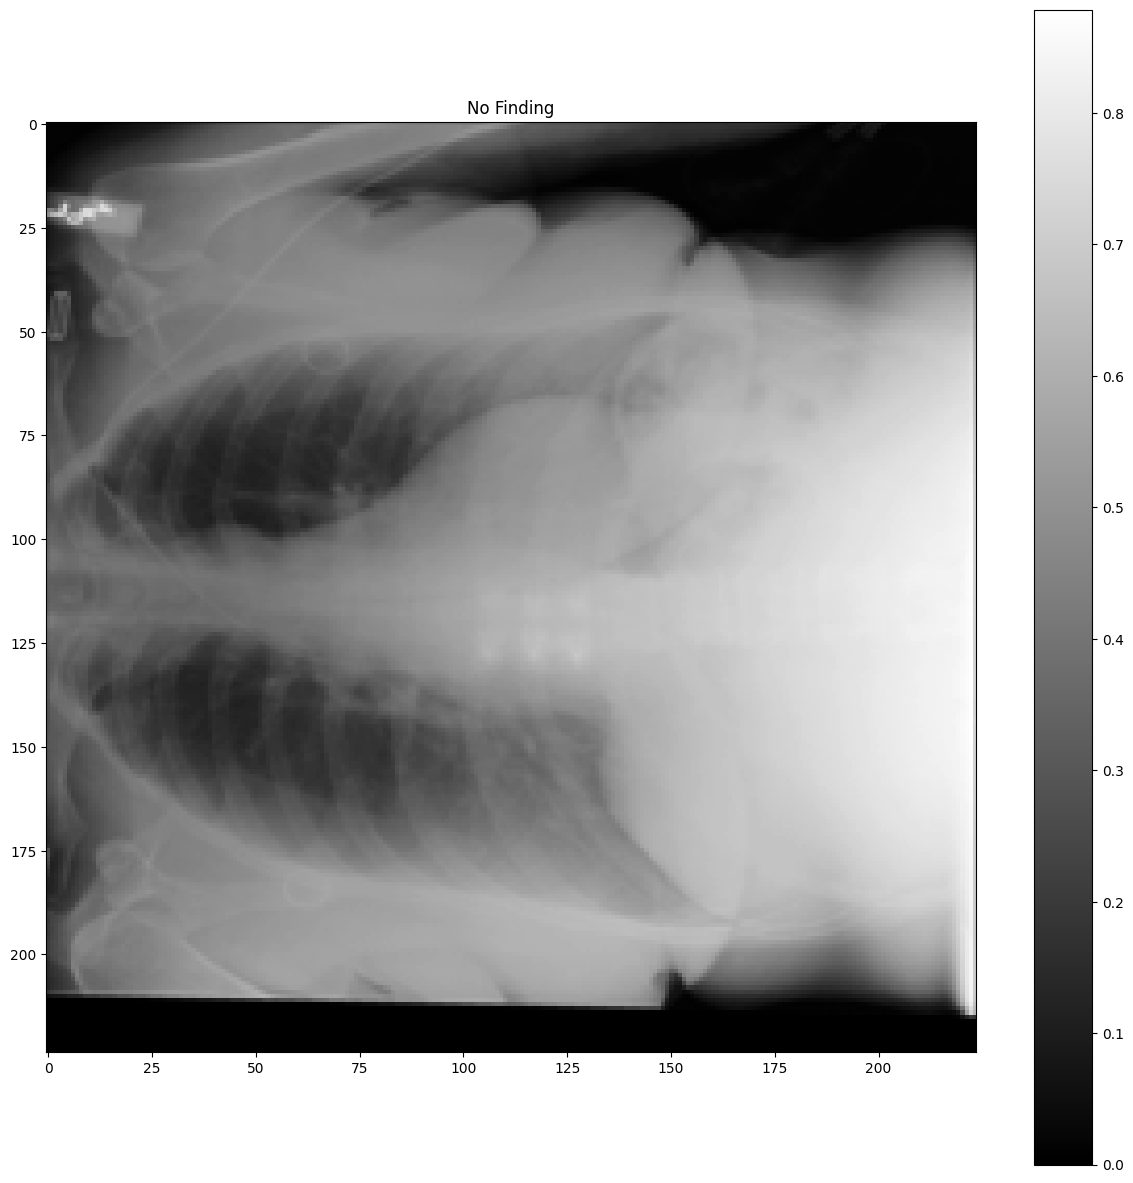

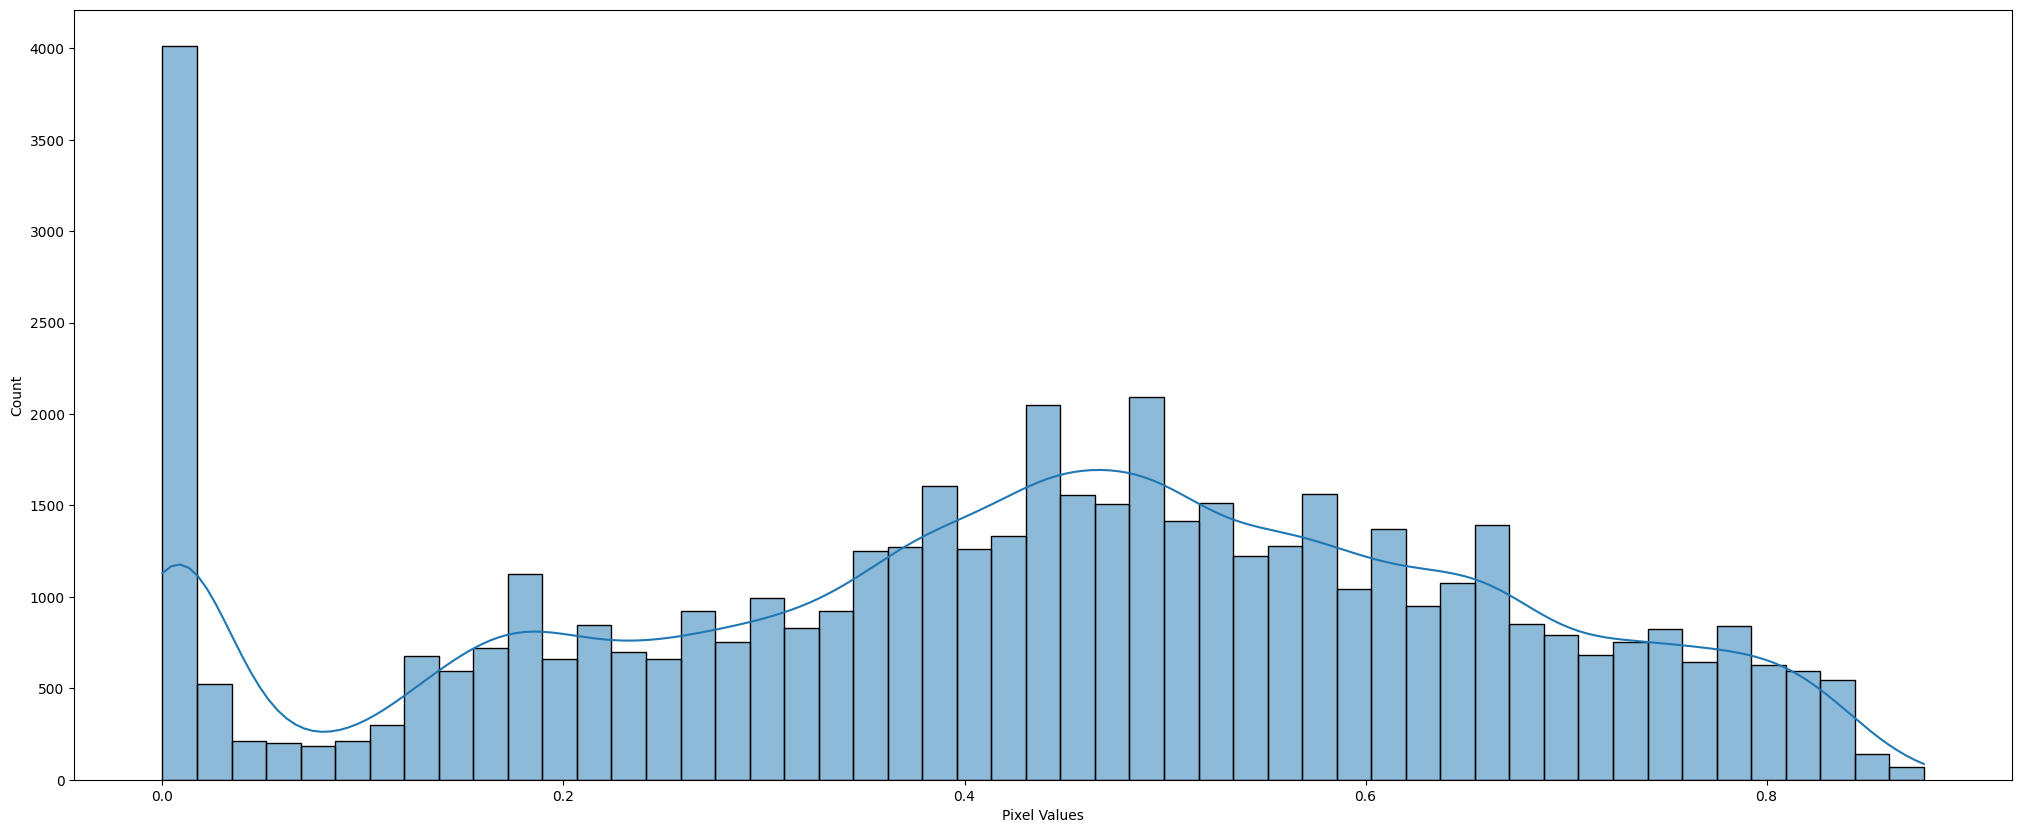

In [ ]:
num = np.random.randint(trainset_filtered.shape[0])
sample = plt.imread(os.path.join(img_dir,trainset_filtered.iloc[[num]]["Image"].values[0]))
plt.figure(figsize=(15, 15))
plt.title(dataframe[dataframe["Image Index"] == trainset_filtered.iloc[[num]]["Image"].values[0]].values[0][1])
plt.imshow(sample, cmap = 'gray')
plt.colorbar()
trainset_filtered.iloc[[num]]

print("Maximum Pixel Value: ", sample.max())
print("Minimum Pixel Value: ", sample.min())
print(f"Image dimension: {sample.shape[0]} x {sample.shape[1]} ")

fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values")
print("Mean - Pixel Value: ", sample.mean())
print("Std Deviation Pixel Value: ", sample.std())
sns.histplot(sample.ravel(), ax = ax, kde = True)

In [ ]:
#Correct the labels variable
labels = desired_labels
labels

['No Finding', 'Nodule', 'Effusion', 'Pneumothorax', 'Mass', 'Cardiomegaly']

Found 61214 validated image filenames.
Found 61214 validated image filenames.
Found 12349 validated image filenames.
Found 13069 validated image filenames.


Mean of Pixel Values - Standardized:  9.925998e-07
Standard Deviation of Pixel Values - Standardized:  0.9999999
Mean of Pixel Values - Sample:  0.43034914
Standard Deviation of Pixel Values - Sample:  0.22466952


<Axes: xlabel='Pixel Values', ylabel='Count'>

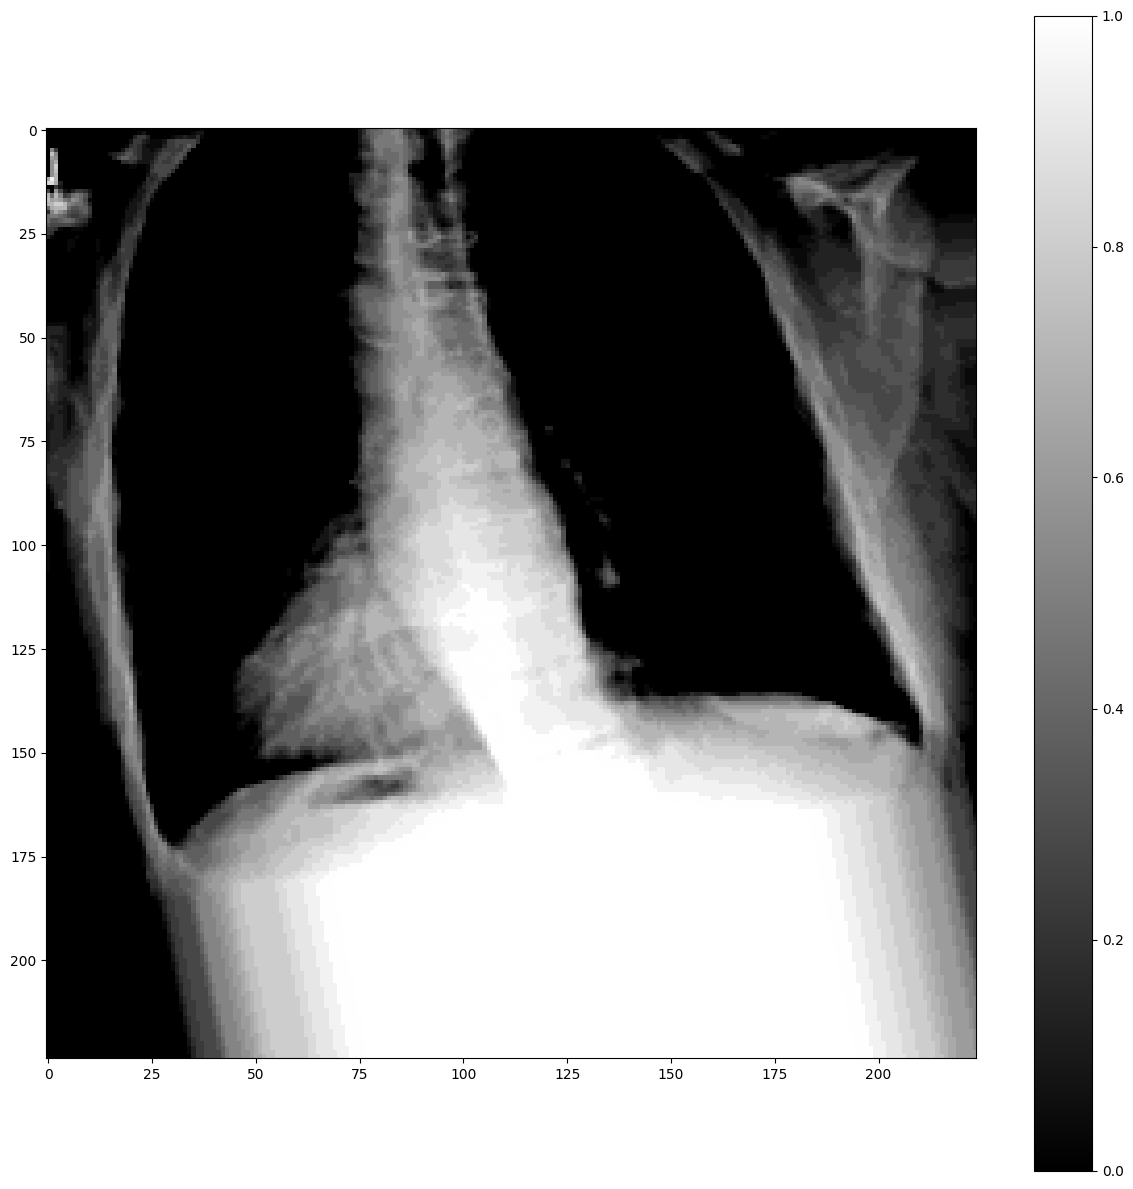

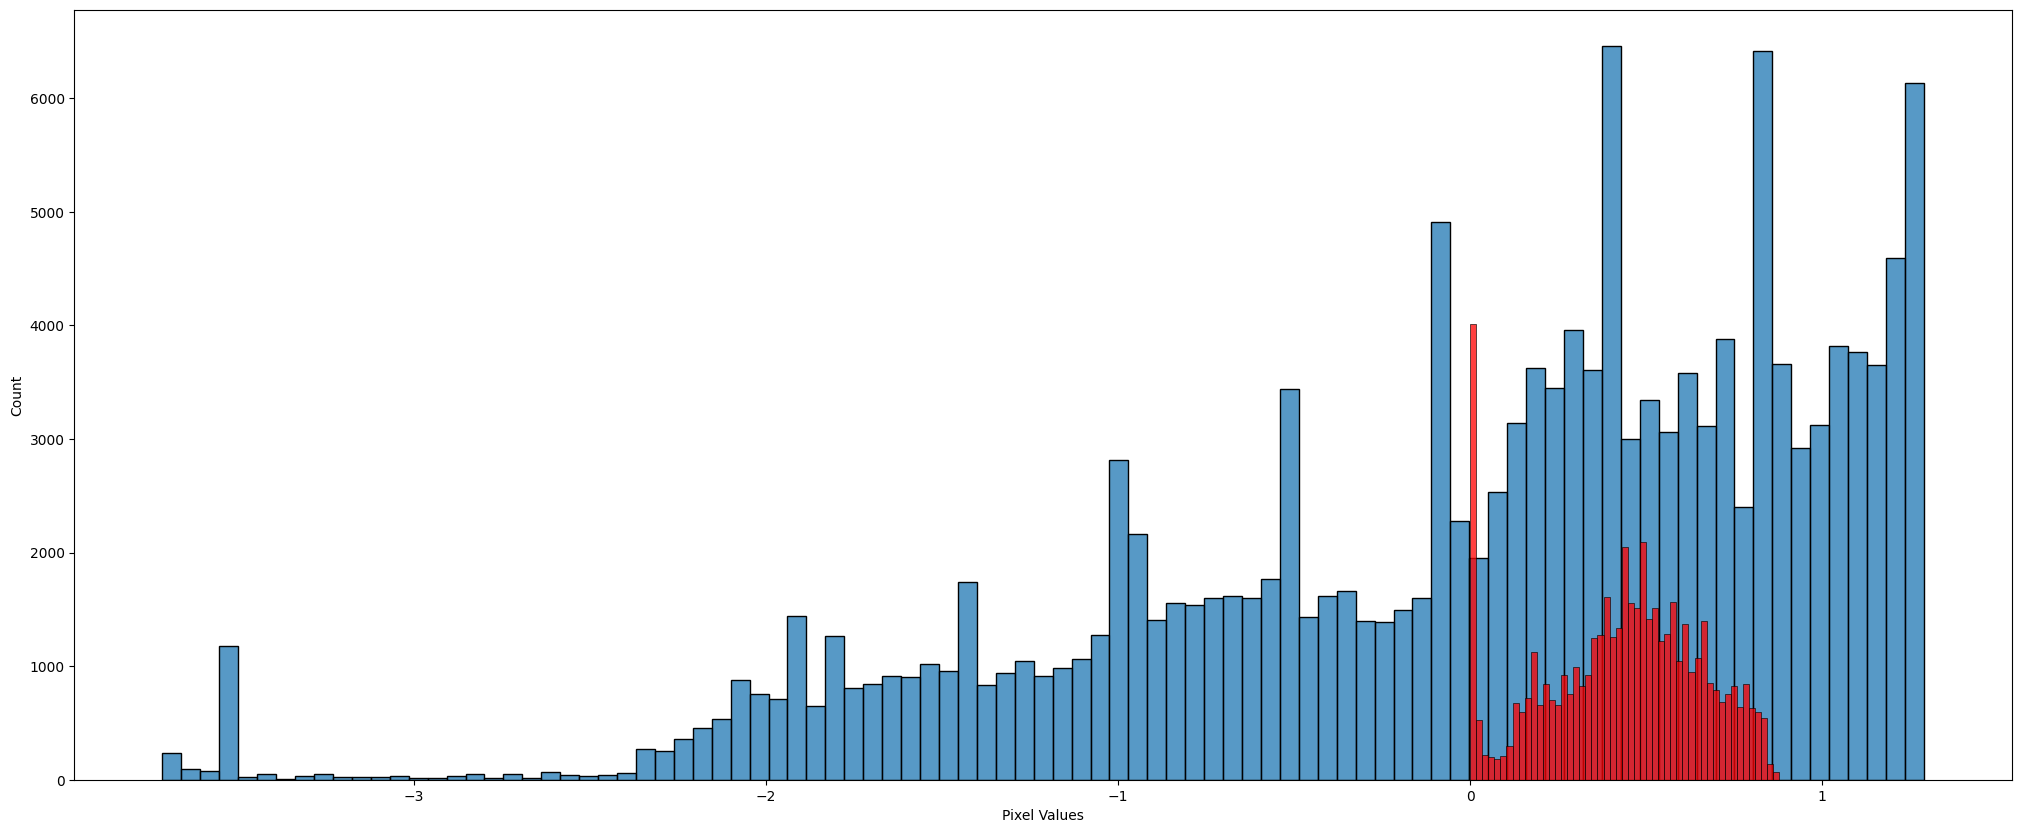

In [ ]:
def adjust_contrast_and_saturation(image):
  # Generate a random contrast factor between 0.4 and 0.9
  contrast_factor = tf.random.uniform([], 0.4, 0.9)
  image = tf.image.adjust_contrast(image, contrast_factor)

  # Generate a random saturation factor between 0.4 and 0.9
  saturation_factor = tf.random.uniform([], 0.4, 0.9)
  image = tf.image.adjust_saturation(image, saturation_factor)

  return image

traingen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=[0.3, 1.2],
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=adjust_contrast_and_saturation
)
img_dir = "/content/images-224/images-224"
bach=32
traingenerator = traingen.flow_from_dataframe(
        dataframe=trainset_filtered,
        directory=img_dir,
        x_col="Image",
        y_col= labels,
        class_mode="raw",
        batch_size= bach,
        shuffle=False,
        target_size=(224,224)
)
#Standardizing featurewise as we don't process images as groups rather one-by-one
imagegen = ImageDataGenerator().flow_from_dataframe(dataframe = trainset_filtered,
                                                    directory = img_dir,
                                                    x_col = "Image",
                                                    y_col = labels, class_mode = "raw",
                                                    batch_size= bach,
                                                    shuffle=False,
                                                    target_size=(224,224))
train_sample = next(imagegen)[0]
imagegen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization= True)
imagegen.fit(train_sample)
valgenerator = imagegen.flow_from_dataframe(dataframe = valset_filtered,
                                            directory = img_dir,
                                            x_col = "Image",
                                            y_col = labels,
                                            class_mode = "raw",
                                            batch_size= bach,
                                            shuffle=False,
                                            target_size=(224,224))
testgenerator = imagegen.flow_from_dataframe(dataframe = testset_filtered,
                                             directory = img_dir,
                                             x_col = "Image",
                                             y_col = labels,
                                             class_mode = "raw",
                                             batch_size= bach,
                                             shuffle=False,
                                             target_size=(224,224))


#Taking a random sample standardized image
num = np.random.randint(len(traingenerator))

item, value = traingenerator.__getitem__(num)
plt.figure(figsize=(15, 15))
plt.imshow(item[0], cmap = 'gray')
plt.colorbar()

#Plotting the histogram of original and standardized pixel intensities
fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values")
print("Mean of Pixel Values - Standardized: ", item[0].mean())
print("Standard Deviation of Pixel Values - Standardized: ", item[0].std())
print("Mean of Pixel Values - Sample: ", sample.mean())
print("Standard Deviation of Pixel Values - Sample: ", sample.std())
sns.histplot(item[0].ravel(), ax = ax, kde = False)
sns.histplot(sample.ravel(), ax = ax, kde = False, color = "red")

<Figure size 2000x1500 with 0 Axes>

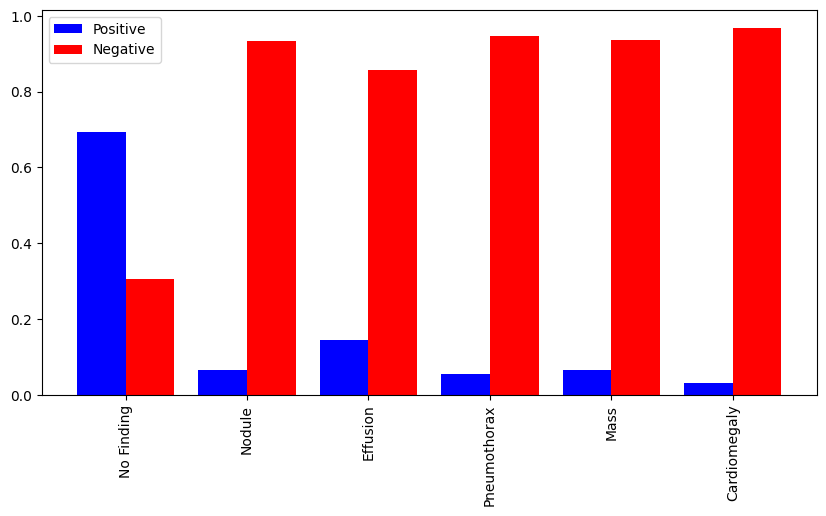

<Figure size 2000x1500 with 0 Axes>

In [ ]:
# Calculate positive and negative frequencies for each label
positive_freqs = trainset_filtered[labels].sum().values / trainset_filtered.shape[0]  # Assuming labels are 1 for positive, 0 for negative
negative_freqs = 1 - positive_freqs

data = {
    'Class': labels,
    'Positive': positive_freqs, #* negative_freqs, #Removed
    'Negative': negative_freqs #* positive_freqs #Removed
}

X_axis = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(X_axis-0.2, data['Positive'], width=0.4, color='b', label = "Positive")
ax.bar(X_axis+0.2, data['Negative'], width=0.4, color='r', label = 'Negative')
plt.xticks(X_axis, labels, rotation = 90)
plt.legend()
plt.figure(figsize=(20,15))

In [ ]:
save_dir = '/content/saved_models'

In [ ]:

def create_model():

    input_tensor = Input(shape=(224, 224, 3))

    ConvNeXtBase_base = ConvNeXtBase(
        weights='imagenet',
        include_top=False,
        input_tensor=input_tensor
    )
    for layer in ConvNeXtBase_base.layers[:-5]:
        layer.trainable = False
    x_ConvNeXtBase = ConvNeXtBase_base.output
    x_ConvNeXtBase = GlobalAveragePooling2D()(x_ConvNeXtBase)
    x_ConvNeXtBase = Dense(256, activation='relu')(x_ConvNeXtBase)

    vgg16_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_tensor=input_tensor
    )
    for layer in vgg16_base.layers[:-5]:
        layer.trainable = False
    x_vgg16 = vgg16_base.output
    x_vgg16 = GlobalAveragePooling2D()(x_vgg16)
    x_vgg16 = Dense(256, activation='relu')(x_vgg16)

    merged = concatenate([x_ConvNeXtBase, x_vgg16])

    output = Dense(len(labels), activation='sigmoid')(merged)

    model = Model(inputs=input_tensor, outputs=output)
    return model

model = create_model()
model.summary()

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_pres… │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stem  │ (None, 56, 56,    │      6,528 │ convnext_base_pr… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │      6,400 │ convnext_base_st… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        128 │ convnext_base_st… │
│ (LayerScale)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │          0 │ convnext_base_st… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ convnext_base_st… │
│                     │ 128)              │            │ convnext_base_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │      6,400 │ add[0][0]         │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        256 │ convnext_base_st… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     66,048 │ convnext_base_st… │
│ (Dense)             │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │          0 │ convnext_base_st… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │     65,664 │ convnext_base_st… │
│ (Dense)             │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_base_stag… │ (None, 56, 56,    │        128 │ convnext_base_st

 Total params: 102,677,958 (391.69 MB)

 Trainable params: 11,674,630 (44.54 MB)

 Non-trainable params: 91,003,328 (347.15 MB)

In [ ]:
def weighted_cross_entropy(y_true, y_pred):
    # Calculate positive and negative weights based on class frequencies in your dataset.
    positive_weights = tf.constant(positive_freqs, dtype=tf.float32)  # Example positive weights
    negative_weights = tf.constant(negative_freqs, dtype=tf.float32)  # Example negative weights

    # Calculate the weighted loss
    loss = -(y_true * tf.math.log(y_pred + 1e-7) * positive_weights + (1 - y_true) * tf.math.log(1 - y_pred + 1e-7) * negative_weights)

    return tf.reduce_mean(loss)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Function to train the model and save it
def train_and_save_model(model_name):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=weighted_cross_entropy, metrics=['accuracy'])

    # Define callbacks
    checkpoint = ModelCheckpoint(f'{model_name}.keras',
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        traingenerator,
        epochs=100,
        validation_data=valgenerator,
        callbacks=[checkpoint, early_stopping]
    )

    return history

# Train the model and save it
history = train_and_save_model('ConvNeXtBase+VGG16_chest_xray_ensemble')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6708 - loss: 0.0951
Epoch 1: val_accuracy improved from -inf to 0.63730, saving model to ConvNeXtBase+VGG16_chest_xray_ensemble.keras
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 2352s 1s/step - accuracy: 0.6708 - loss: 0.0951 - val_accuracy: 0.6373 - val_loss: 0.0707
Epoch 2/100
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6960 - loss: 0.0629
Epoch 2: val_accuracy improved from 0.63730 to 0.64013, saving model to ConvNeXtBase+VGG16_chest_xray_ensemble.keras
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 2270s 1s/step - accuracy: 0.6960 - loss: 0.0629 - val_accuracy: 0.6401 - val_loss: 0.0722
Epoch 3/100
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6987 - loss: 0.0618
Epoch 3: val_accuracy improved from 0.64013 to 0.64183, saving model to ConvNeXtBase+VGG16_chest_xray_ensemble.keras
1913/1913 ━━━━━━━━━━━━━━━━━━━━ 2318s 1s/step - accuracy: 0.6987 - loss: 0.0618 - val_accuracy: 0.6418 - val_loss: 0.0700
Epoch 4/100
1913/1913 ━━━

409/409 ━━━━━━━━━━━━━━━━━━━━ 235s 559ms/step
Best threshold for No Finding: 0.09620000000000001
Confusion Matrix for No Finding (Threshold: 0.09620000000000001):
[[   9 4082]
 [   1 8977]]
Specificity for No Finding: 0.002199951112197507
Best threshold for Nodule: 0.0048000000000000004
Confusion Matrix for Nodule (Threshold: 0.0048000000000000004):
[[11062  1116]
 [  610   281]]
Specificity for Nodule: 0.9083593365084579
Best threshold for Effusion: 0.062000000000000006
Confusion Matrix for Effusion (Threshold: 0.062000000000000006):
[[9310 1770]
 [ 456 1533]]
Specificity for Effusion: 0.8402527075812274
Best threshold for Pneumothorax: 0.004300000000000001
Confusion Matrix for Pneumothorax (Threshold: 0.004300000000000001):
[[9681 2413]
 [ 353  622]]
Specificity for Pneumothorax: 0.8004795766495783
Best threshold for Mass: 0.007000000000000001
Confusion Matrix for Mass (Threshold: 0.007000000000000001):
[[11388   937]
 [  535   209]]
Specificity for Mass: 0.9239756592292089
Best thres

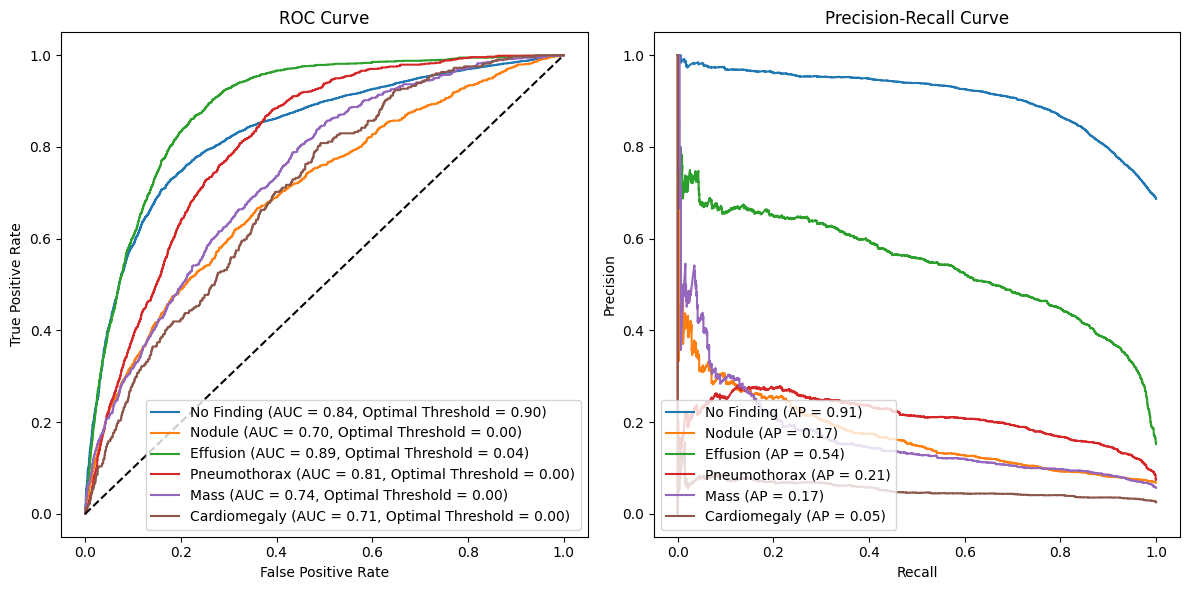

In [ ]:
# Initialize lists to store evaluation metrics for each label
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []
mcc_list = []
auc_pr_list = []
best_thresholds = []
predicted_vals = model.predict(testgenerator)
# Iterate through labels and calculate metrics
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred_probs = predicted_vals[:, i]

        # Find optimal threshold based on F1-score
        best_f1 = -1
        best_thresh = 0
        for thresh in np.arange(0.0001, 0.0999999, 0.0001):  # Iterate through different thresholds
            pred = (pred_probs > thresh).astype(int)
            f1 = f1_score(gt, pred)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)
        print(f"Best threshold for {labels[i]}: {best_thresh}")

        # Use the best threshold for evaluation
        pred = (pred_probs > best_thresh).astype(int)

        precision = precision_score(gt, pred)
        recall = recall_score(gt, pred)
        f1 = f1_score(gt, pred)
        accuracy = accuracy_score(gt, pred)
        mcc = matthews_corrcoef(gt, pred)
        auc_pr = average_precision_score(gt, pred_probs)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        mcc_list.append(mcc)
        auc_pr_list.append(auc_pr)

        # Calculate Confusion Matrix
        cm = confusion_matrix(gt, pred)
        print(f"Confusion Matrix for {labels[i]} (Threshold: {best_thresh}):")
        print(cm)
        # Calculate Specificity
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        print(f"Specificity for {labels[i]}: {specificity}")

    except ValueError:
        pass


# Store the metrics in a DataFrame for better presentation
metrics_df = pd.DataFrame({
    'Label': labels,
    'Best Threshold': best_thresholds,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Score': f1_list,
    'Accuracy': accuracy_list,
    'MCC': mcc_list,
    'AUC-PR': auc_pr_list
})

print(metrics_df)

# Plot ROC and PR curves for each label in one plot
plt.figure(figsize=(12, 6))

# ROC curve
plt.subplot(1, 2, 1)
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred = predicted_vals[:, i]
        fpr, tpr, thresholds = roc_curve(gt, pred)

        # Calculate Youden's J for each threshold
        youden_j = tpr - fpr

        # Find the optimal threshold based on Youden's J
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        roc_auc = roc_auc_score(gt, pred)
        plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f}, Optimal Threshold = {optimal_threshold:.2f})")
    except ValueError:
        pass
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# PR curve
plt.subplot(1, 2, 2)
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred = predicted_vals[:, i]
        precision, recall, _ = precision_recall_curve(gt, pred)
        average_precision = average_precision_score(gt, pred)
        plt.plot(recall, precision, label=f"{labels[i]} (AP = {average_precision:.2f})")
    except ValueError:
        pass
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

409/409 ━━━━━━━━━━━━━━━━━━━━ 218s 532ms/step
Best threshold for No Finding: 0.09730000000000001
Confusion Matrix for No Finding (Threshold: 0.09730000000000001):
[[  10 4081]
 [   2 8976]]
Specificity for No Finding: 0.0024443901246638962
Best threshold for Nodule: 0.0102
Confusion Matrix for Nodule (Threshold: 0.0102):
[[11977   201]
 [  803    88]]
Specificity for Nodule: 0.9834948267367384
Best threshold for Effusion: 0.09830000000000001
Confusion Matrix for Effusion (Threshold: 0.09830000000000001):
[[9858 1222]
 [ 726 1263]]
Specificity for Effusion: 0.8897111913357401
Best threshold for Pneumothorax: 0.012
Confusion Matrix for Pneumothorax (Threshold: 0.012):
[[11775   319]
 [  852   123]]
Specificity for Pneumothorax: 0.9736232842731933
Best threshold for Mass: 0.0184
Confusion Matrix for Mass (Threshold: 0.0184):
[[12255    70]
 [  698    46]]
Specificity for Mass: 0.9943204868154158
Best threshold for Cardiomegaly: 0.0086
Confusion Matrix for Cardiomegaly (Threshold: 0.0086):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


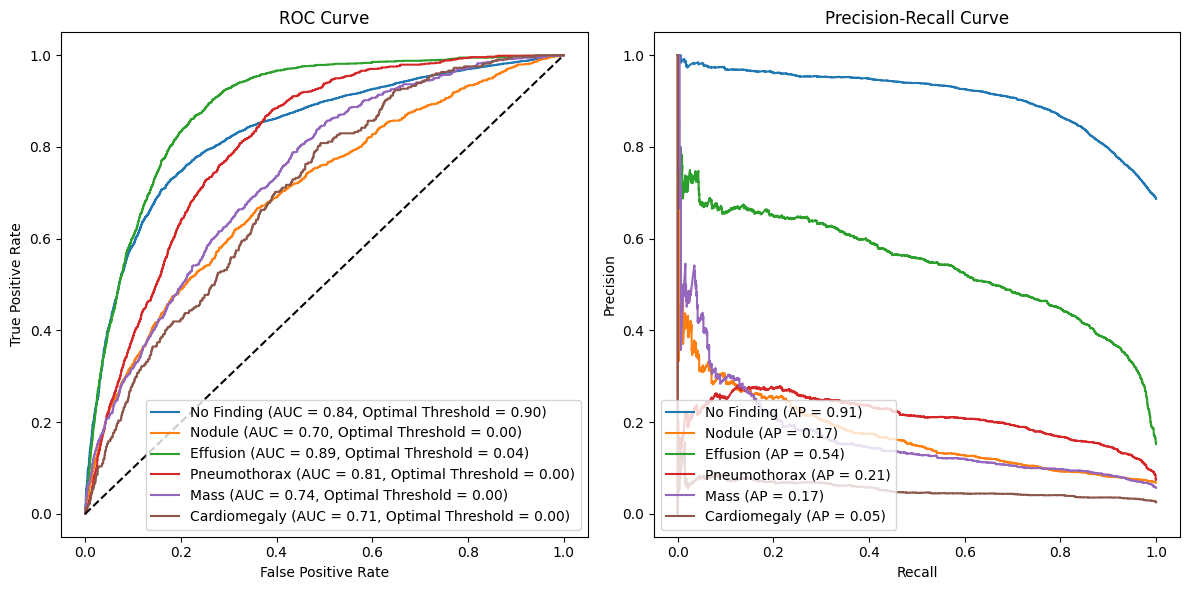

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             matthews_corrcoef, average_precision_score, confusion_matrix,
                             roc_curve, roc_auc_score, precision_recall_curve)

weighted_precision_list = []
weighted_recall_list = []
weighted_f1_list = []
accuracy_list = []
mcc_list = []
auc_pr_list = []
best_thresholds = []

predicted_vals = model.predict(testgenerator)
all_gt = np.array(testgenerator.labels)
all_pred_probs = predicted_vals

for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred_probs = all_pred_probs[:, i]

        best_f1 = -1
        best_thresh = 0
        for thresh in np.arange(0.0001, 0.0999999, 0.0001):
            pred = (pred_probs > thresh).astype(int)
            f1 = f1_score(gt, pred, average="weighted")
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)
        print(f"Best threshold for {labels[i]}: {best_thresh}")

        pred = (pred_probs > best_thresh).astype(int)

        weighted_precision = precision_score(gt, pred, average="weighted")
        weighted_recall = recall_score(gt, pred, average="weighted")
        weighted_f1 = f1_score(gt, pred, average="weighted")
        accuracy = accuracy_score(gt, pred)
        mcc = matthews_corrcoef(gt, pred)
        auc_pr = average_precision_score(gt, pred_probs)

        weighted_precision_list.append(weighted_precision)
        weighted_recall_list.append(weighted_recall)
        weighted_f1_list.append(weighted_f1)
        accuracy_list.append(accuracy)
        mcc_list.append(mcc)
        auc_pr_list.append(auc_pr)

        cm = confusion_matrix(gt, pred)
        print(f"Confusion Matrix for {labels[i]} (Threshold: {best_thresh}):")
        print(cm)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            print(f"Specificity for {labels[i]}: {specificity}")

    except ValueError:
        pass

metrics_df = pd.DataFrame({
    'Label': labels,
    'Best Threshold': best_thresholds,
    'Weighted Precision': weighted_precision_list,
    'Weighted Recall': weighted_recall_list,
    'Weighted F1-Score': weighted_f1_list,
    'Accuracy': accuracy_list,
    'MCC': mcc_list,
    'AUC-PR': auc_pr_list
})

print(metrics_df)

print("\nOverall Weighted Metrics:")
print(f"Mean Weighted Precision: {np.mean(weighted_precision_list):.4f}")
print(f"Mean Weighted Recall: {np.mean(weighted_recall_list):.4f}")
print(f"Mean Weighted F1-Score: {np.mean(weighted_f1_list):.4f}")
print(f"Mean Accuracy: {np.mean(accuracy_list):.4f}")
print(f"Mean MCC: {np.mean(mcc_list):.4f}")
print(f"Mean AUC-PR: {np.mean(auc_pr_list):.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        fpr, tpr, thresholds = roc_curve(gt, pred)

        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = thresholds[optimal_idx]

        roc_auc = roc_auc_score(gt, pred)
        plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f}, Optimal Threshold = {optimal_threshold:.2f})")
    except ValueError:
        pass
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        precision, recall, _ = precision_recall_curve(gt, pred)
        average_precision = average_precision_score(gt, pred)
        plt.plot(recall, precision, label=f"{labels[i]} (AP = {average_precision:.2f})")
    except ValueError:
        pass
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             matthews_corrcoef, average_precision_score, confusion_matrix,
                             roc_curve, roc_auc_score, precision_recall_curve)

# Assume 'model', 'testgenerator', and 'labels' are already defined.
# 'testgenerator' should have a 'labels' attribute (ground truth)
# and 'model.predict' should return predicted probabilities.

# Mock data for demonstration purposes if model and testgenerator are not available.
# Remove or comment out this section if you have your actual model and data.
class MockGenerator:
    def __init__(self, labels_data, pred_probs_data):
        self.labels = labels_data
        self.pred_probs = pred_probs_data

mock_labels = ['No Finding', 'Nodule', 'Effusion', 'Pneumothorax', 'Mass', 'Cardiomegaly']
num_samples_mock = 500 # Number of mock test samples

mock_all_gt = np.zeros((num_samples_mock, len(mock_labels)))
mock_all_pred_probs = np.random.rand(num_samples_mock, len(mock_labels))

# Simulate imbalanced data for 'No Finding' (more frequent)
mock_all_gt[:, 0] = np.random.randint(0, 2, size=num_samples_mock)
# Simulate other classes with lower frequency (e.g., 10% positive)
for j in range(1, len(mock_labels)):
    mock_all_gt[:, j] = np.random.choice([0, 1], size=num_samples_mock, p=[0.9, 0.1])

testgenerator = MockGenerator(mock_all_gt, mock_all_pred_probs)
labels = mock_labels
# End of mock data

# Replace these lines with your actual model's output
predicted_vals = testgenerator.pred_probs # Using mock data
all_gt = testgenerator.labels # Using mock data

precision_per_class = []
recall_per_class = []
f1_per_class = []
accuracy_per_class = []
mcc_per_class = []
auc_pr_per_class = []
best_thresholds = []

# Loop to calculate metrics for each class individually
for i in range(len(labels)):
    try:
        gt = all_gt[:, i] # Ground Truth for the current class
        pred_probs = all_pred_probs[:, i] # Predicted probabilities for the current class

        # Find the best threshold by optimizing F1-Score for the current class
        best_f1 = -1
        best_thresh = 0
        # Iterate through a range of thresholds. Adjust range if needed based on your model's output distribution.
        for thresh in np.arange(0.0001, 0.5, 0.0001):
            pred = (pred_probs > thresh).astype(int)
            # 'binary' average is for a single target class with 0 or 1 labels
            f1 = f1_score(gt, pred, average="binary", zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)
        print(f"Best threshold for {labels[i]}: {best_thresh:.4f}")

        # Use the best threshold to calculate final metrics for the current class
        pred = (pred_probs > best_thresh).astype(int)

        # Calculate Precision, Recall, F1-Score for each class
        # 'average="binary"' is appropriate for calculating metrics for a single class in a multi-label setting
        current_precision = precision_score(gt, pred, average="binary", zero_division=0)
        current_recall = recall_score(gt, pred, average="binary", zero_division=0)
        current_f1 = f1_score(gt, pred, average="binary", zero_division=0)

        accuracy = accuracy_score(gt, pred)
        mcc = matthews_corrcoef(gt, pred)
        # average_precision_score by default calculates for the positive class (binary)
        auc_pr = average_precision_score(gt, pred_probs)

        precision_per_class.append(current_precision)
        recall_per_class.append(current_recall)
        f1_per_class.append(current_f1)
        accuracy_per_class.append(accuracy)
        mcc_per_class.append(mcc)
        auc_pr_per_class.append(auc_pr)

        # Display Confusion Matrix
        cm = confusion_matrix(gt, pred)
        print(f"Confusion Matrix for {labels[i]} (Threshold: {best_thresh:.4f}):")
        print(cm)

        # Calculate Specificity (True Negative Rate) if both classes (0 and 1) are present in gt
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            print(f"Specificity for {labels[i]}: {specificity:.4f}")

    except ValueError as e:
        print(f"Error processing {labels[i]}: {e}")
        # Append NaN or 0 if an error occurs to maintain DataFrame structure
        best_thresholds.append(np.nan)
        precision_per_class.append(np.nan)
        recall_per_class.append(np.nan)
        f1_per_class.append(np.nan)
        accuracy_per_class.append(np.nan)
        mcc_per_class.append(np.nan)
        auc_pr_per_class.append(np.nan)

# Create DataFrame to display per-class results
metrics_df = pd.DataFrame({
    'Label': labels,
    'Best Threshold': [f"{th:.4f}" if not np.isnan(th) else 'N/A' for th in best_thresholds],
    'Precision': [f"{p:.6f}" for p in precision_per_class],
    'Recall': [f"{r:.6f}" for r in recall_per_class],
    'F1-Score': [f"{f:.6f}" for f in f1_per_class],
    'Accuracy': [f"{a:.6f}" for a in accuracy_per_class],
    'MCC': [f"{m:.6f}" for m in mcc_per_class],
    'AUC-PR': [f"{ap:.6f}" for ap in auc_pr_per_class]
})

print("\nMetrics per Class (Calculated with best F1-Score threshold for each class):")
print(metrics_df.to_string()) # Use to_string() to prevent truncation

# Calculate Overall Mean (Macro-averaged) Metrics
# These means give equal weight to each class.
print("\nOverall Mean (Macro-averaged) Metrics (Simple average of individual class metrics):")
print(f"Mean Precision: {np.nanmean(np.array(precision_per_class).astype(float)):.4f}")
print(f"Mean Recall: {np.nanmean(np.array(recall_per_class).astype(float)):.4f}")
print(f"Mean F1-Score: {np.nanmean(np.array(f1_per_class).astype(float)):.4f}")
print(f"Mean Accuracy: {np.nanmean(np.array(accuracy_per_class).astype(float)):.4f}")
print(f"Mean MCC: {np.nanmean(np.array(mcc_per_class).astype(float)):.4f}")
print(f"Mean AUC-PR: {np.nanmean(np.array(auc_pr_per_class).astype(float)):.4f}")


# Calculate Overall Weighted AUC-ROC and AUC-PR
# These metrics use 'average='weighted'' which weights each class by its "support" (number of true samples).
print("\nOverall Weighted Metrics (Averaged across all labels, weighted by support):")
try:
    # Overall Weighted AUC-ROC
    overall_weighted_auc_roc = roc_auc_score(all_gt, all_pred_probs, average='weighted')
    print(f"Overall Weighted AUC-ROC: {overall_weighted_auc_roc:.4f}")
except ValueError as e:
    print(f"Could not calculate Overall Weighted AUC-ROC: {e}. Ensure each class has at least one positive and one negative sample in all_gt.")

try:
    # Overall Weighted AUC-PR
    overall_weighted_auc_pr = average_precision_score(all_gt, all_pred_probs, average='weighted')
    print(f"Overall Weighted AUC-PR: {overall_weighted_auc_pr:.4f}")
except ValueError as e:
    print(f"Could not calculate Overall Weighted AUC-PR: {e}. Ensure each class has at least one positive sample in all_gt.")


# Plotting ROC and Precision-Recall Curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        # ROC curve requires at least one positive and one negative sample
        if len(np.unique(gt)) == 2:
            fpr, tpr, thresholds = roc_curve(gt, pred)
            roc_auc = roc_auc_score(gt, pred)

            # Calculate Youden's J for optimal threshold on ROC curve
            youden_j = tpr - fpr
            optimal_idx = np.argmax(youden_j)
            optimal_threshold = thresholds[optimal_idx]

            plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f}, Opt. Thresh = {optimal_threshold:.2f})")
    except ValueError:
        pass
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right', fontsize='small')

plt.subplot(1, 2, 2)
for i in range(len(labels)):
    try:
        gt = all_gt[:, i]
        pred = all_pred_probs[:, i]
        # Precision-Recall curve requires at least one positive sample
        if np.sum(gt) > 0:
            precision, recall, _ = precision_recall_curve(gt, pred)
            average_precision = average_precision_score(gt, pred)
            plt.plot(recall, precision, label=f"{labels[i]} (AP = {average_precision:.2f})")
    except ValueError:
        pass
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='lower left', fontsize='small')

plt.tight_layout()
plt.show()